[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mfurio93/Used-Cars-Dataset/blob/main/01%20-%20Data%20%20Exploration.ipynb)

In [4]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# File importation and cleaning

We now import the .csv file obtained from https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data.

It contains all relevant information that Craigslist provides on car sales including columns like price, cylinders, manufacturer, latitude, and 21 other categories.

Pandas informs us that we're working with a pretty large dataset of over 400000 entries.

Note: due to the massive size of the file (over 1 GB), the next code block might take around 2 minutes to process.

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Pt1akrURtchh4elqaWo4n_bskLI4nJme'
download = drive.CreateFile({'id':file_id})
download.GetContentFile('file.csv')

import pandas as pd
import numpy as np
df = pd.read_csv("file.csv")
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.shape

(426880, 26)

# Analysis of missing data

Through the use of Pandas, we can see that there are columns with way too much missing data, so we'll delete those columns entirely. Others, such as latitude or longitude, are likely not useful for our models.

Additionally, the columns where there is a more despreciable amount of missing data will be kept, however, the rows with the missing data of these columns will also be deleted.

As a complementary step, we delete all duplicate entries within the dataframe.

Finally, we look at the unique values found within some columns, and decide to delete rows with questionable contents, such as "parts only" under "title_status" since we no longer have information on what parts are being sold. We also removed all cars before 1970 as (upon inspection of the .csv), there were not enough of them to create a trustable model.

In [5]:
#Checking amount of NaN values per column
df.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [6]:
#Likely not useful columns
del df['id']
del df['url']
del df['region_url']
del df['VIN']
del df['image_url']
del df['description']
del df['county']
del df['lat']
del df['long']
del df['posting_date']

In [7]:
#Columns with too much missing data
del df['condition']
del df['cylinders']
del df['drive']
del df['size']
del df['paint_color']
del df['type']

In [8]:
#Rows with too much missing data
df.fillna(0, inplace=True)
df.drop(df[(df['price'] == 0)].index, inplace=True)
df.drop(df[(df['year'] == 0)].index, inplace=True)
df.drop(df[(df['manufacturer'] == 0)].index, inplace=True)
df.drop(df[(df['model'] == 0)].index, inplace=True)
df.drop(df[(df['fuel'] == 0)].index, inplace=True)
df.drop(df[(df['odometer'] == 0)].index, inplace=True)
df.drop(df[(df['title_status'] == 0)].index, inplace=True)
df.drop(df[(df['transmission'] == 0)].index, inplace=True)

In [9]:
#Dropping duplicates
df.drop_duplicates(inplace=True)

In [15]:
#Looking at unique values within certain columns
print(np.unique(df["year"]))
print(np.unique(df["manufacturer"]))
print(np.unique(df["fuel"]))
print(np.unique(df["title_status"]))
print(np.unique(df["transmission"]))

[1900. 1905. 1913. 1915. 1918. 1921. 1922. 1923. 1924. 1925. 1926. 1927.
 1928. 1929. 1930. 1931. 1932. 1933. 1934. 1935. 1936. 1937. 1938. 1939.
 1940. 1941. 1942. 1943. 1944. 1945. 1946. 1947. 1948. 1949. 1950. 1951.
 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962. 1963.
 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974. 1975.
 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987.
 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999.
 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022.]
['acura' 'alfa-romeo' 'aston-martin' 'audi' 'bmw' 'buick' 'cadillac'
 'chevrolet' 'chrysler' 'datsun' 'dodge' 'ferrari' 'fiat' 'ford' 'gmc'
 'harley-davidson' 'honda' 'hyundai' 'infiniti' 'jaguar' 'jeep' 'kia'
 'land rover' 'lexus' 'lincoln' 'mazda' 'mercedes-benz' 'mercury' 'mini'
 'mitsubishi' 'nissan' 'pontiac' 'porsche' 'ram' 'rover' 'saturn'

In [17]:
#Dropping certain rows according to our criteria
df.drop(df[df['year'] < 1970].index, inplace=True)
df.drop(df[df['fuel'] == "other"].index, inplace=True)
df.drop(df[df['title_status'] == "parts only"].index, inplace=True)
df.drop(df[df['title_status'] == "salvage"].index, inplace=True)

# Analysis of target variable

Now we take a look at how our target variable behaves.

Here we can appreciate several values that seem either off or excessive. To curb this effect, we'll delete all rows whose target variable value is outside of the \$1000 (one thousand) to \$100000 (one hundred thousand).

After this cleaning process, we lost roughly 120000 entries, or about 30% of our dataset, however, we now have a completely filled and unique dataset.

In [19]:
df.price.describe()

count   277044
mean     18832
std      14121
min       1000
25%       7500
50%      15293
75%      26999
max     100000
Name: price, dtype: float64

In [20]:
df.drop(df[df['price'] > 100000].index, inplace=True)
df.drop(df[df['price'] < 1000].index, inplace=True)
df.price.describe()

count   277044
mean     18832
std      14121
min       1000
25%       7500
50%      15293
75%      26999
max     100000
Name: price, dtype: float64

# Correlation matrix between numerical columns

We run a little correlation test between the numerical values of our dataset.

We find that the year of manufacture is strongly correlated to our target variable while the odometer is not. Knowing this, it would be a good idea to remove the odometer column.

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc

In [22]:
corr_matrix = df.corr()

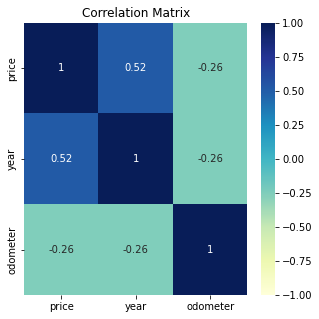

In [23]:
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [25]:
del df['odometer']